In [1]:
import pickle
import matplotlib.pyplot as plt
from astropy.table import Table
import h5py
import fitsio
import numpy as np
import pandas as pd
import healpy as hp
import yaml
import seaborn as sns
from sklearn.model_selection import train_test_split
from Handler.helper_functions import calc_color, flux2mag
from Handler import *

In [2]:
def plot_corner(data_frame, columns, labels, title, ranges=None, show_plot=False, save_plot=False, save_name=None):
    """"""
    import corner
    data = data_frame[columns].values
    ndim = data.shape[1]

    fig, axes = plt.subplots(ndim, ndim, figsize=(18, 10))

    corner.corner(
        data,
        fig=fig,
        bins=20,
        range=ranges,
        color='#51a6fb',
        smooth=True,
        smooth1d=True,
        labels=labels,
        show_titles=True,
        title_fmt=".2f",
        title_kwargs={"fontsize": 12},
        scale_hist=False,
        quantiles=[0.16, 0.5, 0.84],
        density=True,
        plot_datapoints=True,
        plot_density=False,
        plot_contours=True,
        fill_contours=True
    )

    # Manually adding a legend using Line2D
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='#51a6fb', lw=4, label='Balrog')]

    # Adjust labels and titles
    for i in range(ndim):
        ax = axes[i, i]

        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_yticklabels(ax.get_yticks(), rotation=45)

        # Titel mit Quantilen manuell hinzufügen
        legend_elements.append(
            Line2D([0], [0], color='#51a6fb', lw=0, label=f"mean {labels[i]} = {np.mean(data[:, i]):.2f}"))

    fig.legend(handles=legend_elements, loc='upper right', fontsize='x-large')
    fig.suptitle(title, fontsize=16)

    if show_plot is True:
        plt.show()
    if save_plot is True:
        plt.savefig(save_name, dpi=200)

In [3]:
def plot_healpixmap(data_frame, nside, title, col_name, value_range=None, color_map=None, show_plot=False, save_plot=False, save_name=None):
    import healpy as hp
    arr_hpix = data_frame[f"HPIX_{nside}"].to_numpy()
    arr_flux = data_frame[col_name].to_numpy()
    npix = hp.nside2npix(nside)
    hpxmap = np.zeros(npix, dtype=np.float)
    for idx, pix in enumerate(arr_hpix):
        hpxmap[pix] = arr_flux[idx]
    if value_range is None:
        value_range = [np.min(hpxmap), np.max(hpxmap)]
    hp.mollview(
        hpxmap,
        norm="hist",
        nest=True,
        cmap=color_map,
        min=value_range[0],  # Set minimum value of color scale
        max=value_range[1],  # Set maximum value of color scale
    )
    plt.title(title)
    if show_plot is True:
        plt.show()
    if save_plot is True:
        plt.savefig(save_name, dpi=200)

In [4]:
def compute_injection_counts(det_catalog):
    # `true_id` is the DF id
    unique, ucounts = np.unique(det_catalog['ID'], return_counts=True)
    freq = pd.DataFrame()
    freq['ID'] = unique
    freq['injection_counts'] = ucounts
    return det_catalog.merge(freq, on='ID', how='left')

In [5]:
def DeclRaToIndex(decl, RA, NSIDE):
    return hp.pixelfunc.ang2pix(NSIDE, np.radians(-decl + 90.), np.radians(360. + RA), nest=True).astype(int)

In [6]:
def get_yj_transformer(data_frame, columns):
    """"""
    from sklearn.preprocessing import PowerTransformer
    dict_pt = {}
    for col in columns:
        pt = PowerTransformer(method="yeo-johnson")
        pt.fit(np.array(data_frame[col]).reshape(-1, 1))
        data_frame[col] = pt.transform(np.array(data_frame[col]).reshape(-1, 1))
        dict_pt[f"{col} pt"] = pt
    return data_frame, dict_pt

In [7]:
def get_scaler(data_frame):
    """"""
    from sklearn.preprocessing import  MaxAbsScaler
    scaler = MaxAbsScaler()
    scaler.fit(data_frame)
    return scaler

In [120]:
def unsheared_object_cuts(data_frame):
    """"""
    print("Apply unsheared object cuts")
    cuts = (data_frame["unsheared/extended_class_sof"] >= 0) & (data_frame["unsheared/flags_gold"] < 2)
    data_frame = data_frame[cuts]
    print('Length of catalog after applying unsheared object cuts: {}'.format(len(data_frame)))
    return data_frame

In [121]:
def flag_cuts(data_frame):
    """"""
    print("Apply flag cuts")
    cuts = (data_frame["match_flag_1.5_asec"] < 2) & \
           (data_frame["flags_foreground"] == 0) & \
           (data_frame["flags_badregions"] < 2) & \
           (data_frame["flags_footprint"] == 1)
    data_frame = data_frame[cuts]
    print('Length of catalog after applying flag cuts: {}'.format(len(data_frame)))
    return data_frame

In [122]:
def unsheared_mag_cut(data_frame):
    """"""
    print("Apply unsheared mag cuts")
    cuts = (
            (18 < data_frame["unsheared/mag_i"]) &
            (data_frame["unsheared/mag_i"] < 23.5) &
            (15 < data_frame["unsheared/mag_r"]) &
            (data_frame["unsheared/mag_r"] < 26) &
            (15 < data_frame["unsheared/mag_z"]) &
            (data_frame["unsheared/mag_z"] < 26) &
            (-1.5 < data_frame["unsheared/mag_r"] - data_frame["unsheared/mag_i"]) &
            (data_frame["unsheared/mag_r"] - data_frame["unsheared/mag_i"] < 4) &
            (-4 < data_frame["unsheared/mag_z"] - data_frame["unsheared/mag_i"]) &
            (data_frame["unsheared/mag_z"] - data_frame["unsheared/mag_i"] < 1.5)
    )
    data_frame = data_frame[cuts]
    print('Length of catalog after applying unsheared mag cuts: {}'.format(len(data_frame)))
    return data_frame

In [123]:
def unsheared_shear_cuts(data_frame):
    """"""
    print("Apply unsheared shear cuts")
    cuts = (
            (10 < data_frame["unsheared/snr"]) &
            (data_frame["unsheared/snr"] < 1000) &
            (0.5 < data_frame["unsheared/size_ratio"]) &
            (data_frame["unsheared/T"] < 10)
    )
    data_frame = data_frame[cuts]
    data_frame = data_frame[~((2 < data_frame["unsheared/T"]) & (data_frame["unsheared/snr"] < 30))]
    print('Length of catalog after applying unsheared shear cuts: {}'.format(len(data_frame)))
    return data_frame

In [124]:
def mask_cut_healpy(data_frame, master):
    """"""
    import healpy as hp
    import h5py
    print("define mask")
    f = h5py.File(master)
    theta = (np.pi / 180.) * (90. - data_frame['unsheared/dec'].to_numpy())
    phi = (np.pi / 180.) * data_frame['unsheared/ra'].to_numpy()
    gpix = hp.ang2pix(16384, theta, phi, nest=True)
    mask_cut = np.in1d(gpix // (hp.nside2npix(16384) // hp.nside2npix(4096)), f['index/mask/hpix'][:],
                       assume_unique=False)
    data_frame = data_frame[mask_cut]
    npass = np.sum(mask_cut)
    print('pass: ', npass)
    print('fail: ', len(mask_cut) - npass)
    return data_frame

In [125]:
def mask_cut(data_frame, master, prob=False):
    """"""
    import h5py
    print("define mask")
    f = h5py.File(master)
    hpix = data_frame['HPIX_4096'].to_numpy()
    mask_cut = np.in1d(hpix, f['index/mask/hpix'][:], assume_unique=False)
    if prob:
        data_frame.loc[~mask_cut, 'is_in'] = 0
    else:
        data_frame = data_frame[mask_cut]
    npass = np.sum(mask_cut)
    print('pass: ', npass)
    print('fail: ', len(mask_cut) - npass)
    return data_frame

In [126]:
# def mask_cut_astropy(data_frame, master):
#     from astropy_healpix import HEALPix
#     import h5py
#     print("define mask")
#     f = h5py.File(master)
#     coords = SkyCoord(ra=data_frame['unsheared/ra'].to_numpy() * u.deg,
#                       dec=data_frame['unsheared/dec'].to_numpy() * u.deg,
#                       frame='icrs')
#     hp = HEALPix(nside=16384, order='nested', frame='icrs')
#     gpix = hp.skycoord_to_healpix(coords)
#     mask_cut = np.in1d(gpix // (hp.npix // 4096), f['index/mask/hpix'][:],
#                        assume_unique=False)
#     data_frame = data_frame[mask_cut]
#     # data_frame = data_frame[~mask_cut]
#     npass = np.sum(mask_cut)
#     print('pass: ', npass)
#     print('fail: ', len(mask_cut) - npass)
#     return data_frame

def binary_cut(data_frame):
    """"""
    highe_cut = np.greater(np.sqrt(np.power(data_frame['unsheared/e_1'], 2.) + np.power(data_frame['unsheared/e_2'], 2)), 0.8)
    c = 22.5
    m = 3.5
    magT_cut = np.log10(data_frame['unsheared/T']) < (c - flux2mag(data_frame['unsheared/flux_r'])) / m
    binaries = highe_cut * magT_cut

    print("perform binaries cut")
    data_frame = data_frame[~binaries]
    print('len w/ binaries', len(data_frame))
    return data_frame

In [129]:
def apply_cuts(cfg, data_frame):
    """"""
    data_frame = unsheared_object_cuts(data_frame=data_frame)
    data_frame = flag_cuts(data_frame=data_frame)
    data_frame = unsheared_shear_cuts(data_frame=data_frame)
    data_frame = binary_cut(data_frame=data_frame)
    data_frame = mask_cut_healpy(data_frame=data_frame, master=f"{cfg['PATH_DATA']}/{cfg['FILENAME_MASTER_CAT']}")
    data_frame = unsheared_mag_cut(data_frame=data_frame)
    return data_frame

In [8]:
path = "/Users/P.Gebhardt/Development/PhD/Balrog/"
config_file_name = "mac.cfg"
with open(f"{path}config/{config_file_name}", 'r') as fp:
    cfg = yaml.load(fp, Loader=yaml.Loader)

In [9]:
path_plots = "/Users/P.Gebhardt/Documents/gaNdalF/media/Plots"

# Metacalibration Catalog

In [10]:
metacal_data = h5py.File(cfg["PATH_DATA"]+cfg["FILENAME_MCAL"], 'r')
df_mcal = pd.DataFrame()
for i, col in enumerate(cfg["MCAL_COLS"]):
    if col =="unsheared/weight":
        df_mcal[col] = np.array(metacal_data['catalog/' + col])
    else:
        df_mcal[col] = np.array(metacal_data['catalog/' + col]).byteswap().newbyteorder("<")

# Rename some columns
df_mcal = df_mcal[cfg["MCAL_COLS"]]
df_mcal = df_mcal.rename(columns={'unsheared/bal_id': 'bal_id'})
df_mcal = df_mcal.rename(columns={'unsheared/coadd_object_id': 'COADD_OBJECT_ID'})
print('Length of mcal catalog: {}'.format(len(df_mcal)))

Length of mcal catalog: 11250845


In [11]:
for i, col in enumerate(df_mcal.columns):
    print(i, col)

0 COADD_OBJECT_ID
1 unsheared/ra
2 unsheared/dec
3 unsheared/snr
4 unsheared/size_ratio
5 unsheared/flags
6 bal_id
7 unsheared/T
8 unsheared/weight
9 unsheared/extended_class_sof
10 unsheared/flags_gold
11 unsheared/e_1
12 unsheared/e_2
13 unsheared/flux_r
14 unsheared/flux_i
15 unsheared/flux_z
16 unsheared/flux_err_r
17 unsheared/flux_err_i
18 unsheared/flux_err_z


In [12]:
print(df_mcal.isnull().sum())

COADD_OBJECT_ID                      0
unsheared/ra                         0
unsheared/dec                        0
unsheared/snr                        0
unsheared/size_ratio                 0
unsheared/flags                      0
bal_id                               0
unsheared/T                          0
unsheared/weight                     0
unsheared/extended_class_sof         0
unsheared/flags_gold                 0
unsheared/e_1                        0
unsheared/e_2                        0
unsheared/flux_r                     0
unsheared/flux_i                     0
unsheared/flux_z                     0
unsheared/flux_err_r            159946
unsheared/flux_err_i            159946
unsheared/flux_err_z            159946
dtype: int64


In [13]:
print(df_mcal.isnull().sum().sum())

479838


/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_3118/1391280915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)
/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_3118/1391280915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


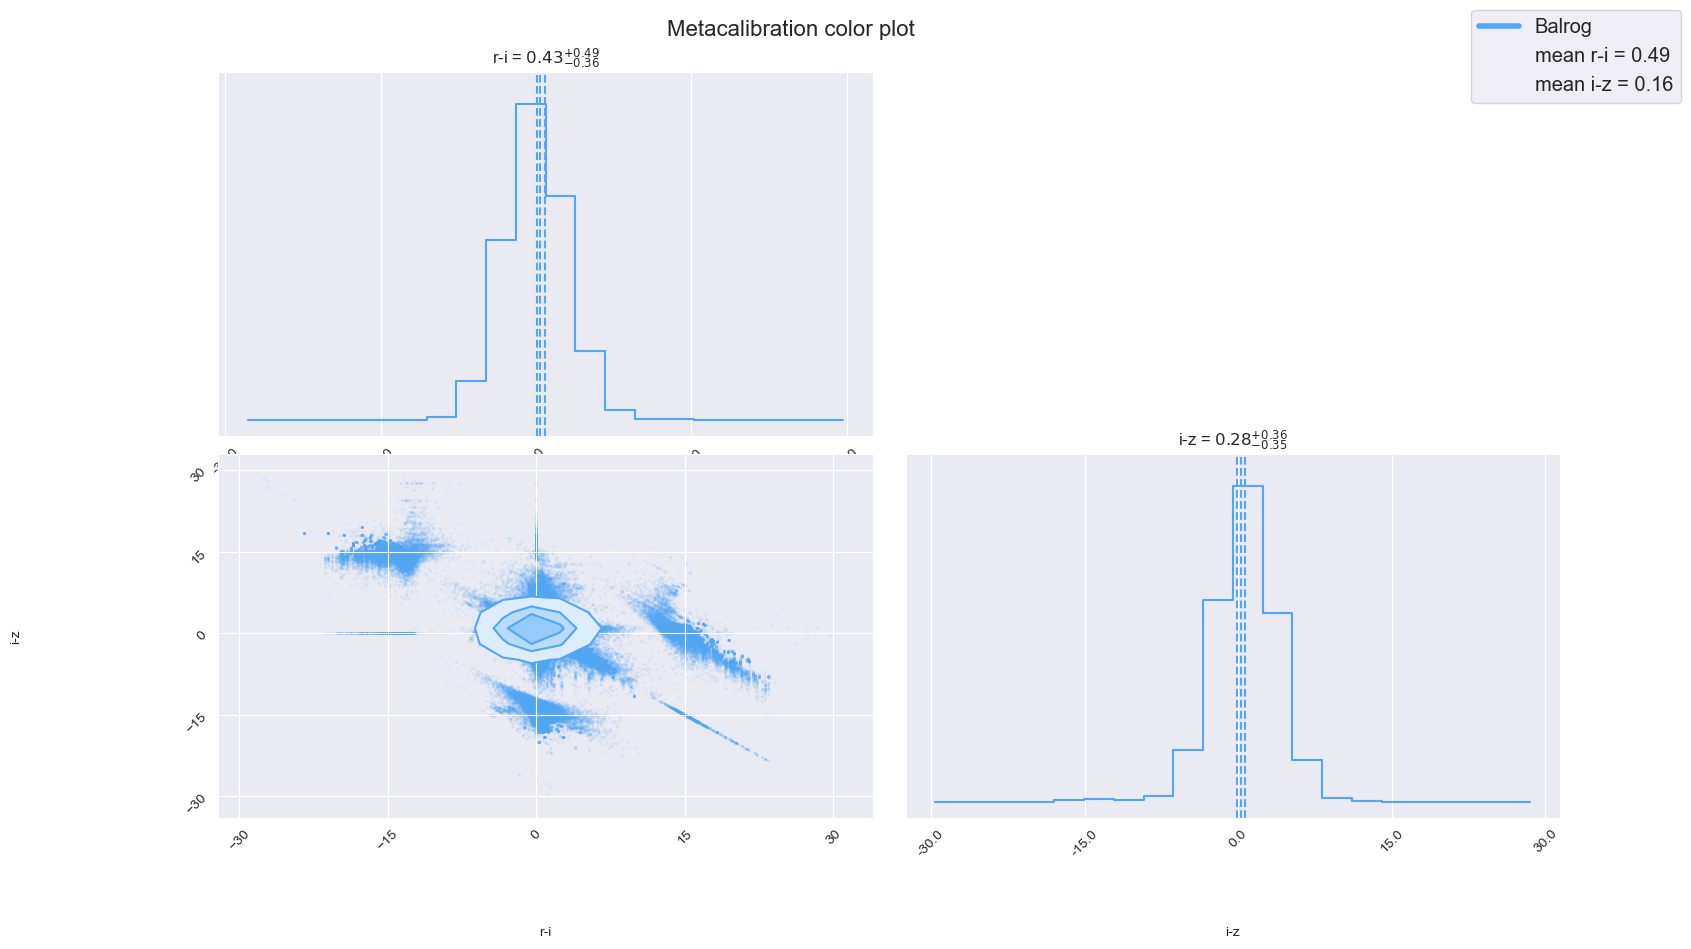

In [14]:
df_mcal["Color unsheared MAG r-i"] = flux2mag(df_mcal["unsheared/flux_r"]) - flux2mag(df_mcal["unsheared/flux_i"])
df_mcal["Color unsheared MAG i-z"] = flux2mag(df_mcal["unsheared/flux_i"]) - flux2mag(df_mcal["unsheared/flux_z"])
plot_corner(
    data_frame=df_mcal,
    columns=["Color unsheared MAG r-i", "Color unsheared MAG i-z"],
    title="Metacalibration color plot",
    labels=["r-i", "i-z"],
    show_plot=False,
    save_plot=True,
    save_name=f"{path_plots}/metacal_cat_color.png",
    ranges=None
)
df_mcal.drop("Color unsheared MAG r-i", axis=1, inplace=True)
df_mcal.drop("Color unsheared MAG i-z", axis=1, inplace=True)

# Detection Catalog

In [15]:
detection_data = Table(fitsio.read(cfg["PATH_DATA"]+cfg["FILENAME_DETECT"]).byteswap().newbyteorder())
df_detect = pd.DataFrame()
for i, col in enumerate(cfg["DETECT_COLS"]):
    df_detect[col] = detection_data[col]
df_detect = df_detect.rename(columns={'true_id': 'ID'})
df_detect = compute_injection_counts(df_detect)
df_detect[f"HPIX_{cfg['NSIDE']}"] = DeclRaToIndex(
np.array(df_detect["true_dec"]), np.array(df_detect["true_ra"]), cfg["NSIDE"])

In [16]:
print('Length of detection catalog: {}'.format(len(df_detect)))

Length of detection catalog: 26442133


In [17]:
for i, col in enumerate(df_detect.keys()):
    print(i, col)

0 bal_id
1 ID
2 detected
3 true_ra
4 true_dec
5 match_flag_1.5_asec
6 flags_foreground
7 flags_badregions
8 flags_footprint
9 injection_counts
10 HPIX_4096


In [18]:
print(df_detect.isnull().sum())

bal_id                 0
ID                     0
detected               0
true_ra                0
true_dec               0
match_flag_1.5_asec    0
flags_foreground       0
flags_badregions       0
flags_footprint        0
injection_counts       0
HPIX_4096              0
dtype: int64


In [19]:
print(df_detect.isnull().sum().sum())

0


# Deep Field Catalog

In [20]:
infile = open(cfg["PATH_DATA"]+cfg["FILENAME_DEEP_FIELD"], 'rb')
df_deep_field = pd.DataFrame(pickle.load(infile, encoding='latin1'))
infile.close()

In [21]:
print('Length of deep field catalog: {}'.format(len(df_deep_field)))

Length of deep field catalog: 2826988


In [22]:
print(df_deep_field.isnull().sum())

ID                            0
RA                            0
DEC                           0
BDF_FLUX_DERED_CALIB_U        0
BDF_FLUX_DERED_CALIB_G        0
BDF_FLUX_DERED_CALIB_R        0
BDF_FLUX_DERED_CALIB_I        0
BDF_FLUX_DERED_CALIB_Z        0
BDF_FLUX_DERED_CALIB_J        0
BDF_FLUX_DERED_CALIB_H        0
BDF_FLUX_DERED_CALIB_K        0
BDF_FLUX_ERR_DERED_CALIB_U    0
BDF_FLUX_ERR_DERED_CALIB_G    0
BDF_FLUX_ERR_DERED_CALIB_R    0
BDF_FLUX_ERR_DERED_CALIB_I    0
BDF_FLUX_ERR_DERED_CALIB_Z    0
BDF_FLUX_ERR_DERED_CALIB_J    0
BDF_FLUX_ERR_DERED_CALIB_H    0
BDF_FLUX_ERR_DERED_CALIB_K    0
BDF_MAG_DERED_CALIB_U         0
BDF_MAG_DERED_CALIB_G         0
BDF_MAG_DERED_CALIB_R         0
BDF_MAG_DERED_CALIB_I         0
BDF_MAG_DERED_CALIB_Z         0
BDF_MAG_DERED_CALIB_J         0
BDF_MAG_DERED_CALIB_H         0
BDF_MAG_DERED_CALIB_K         0
BDF_T                         0
BDF_T_ERR                     0
BDF_G_0                       0
BDF_G_1                       0
TILENAME

In [23]:
print(df_deep_field.isnull().sum().sum())

0


/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_3118/1391280915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)
/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_3118/1391280915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


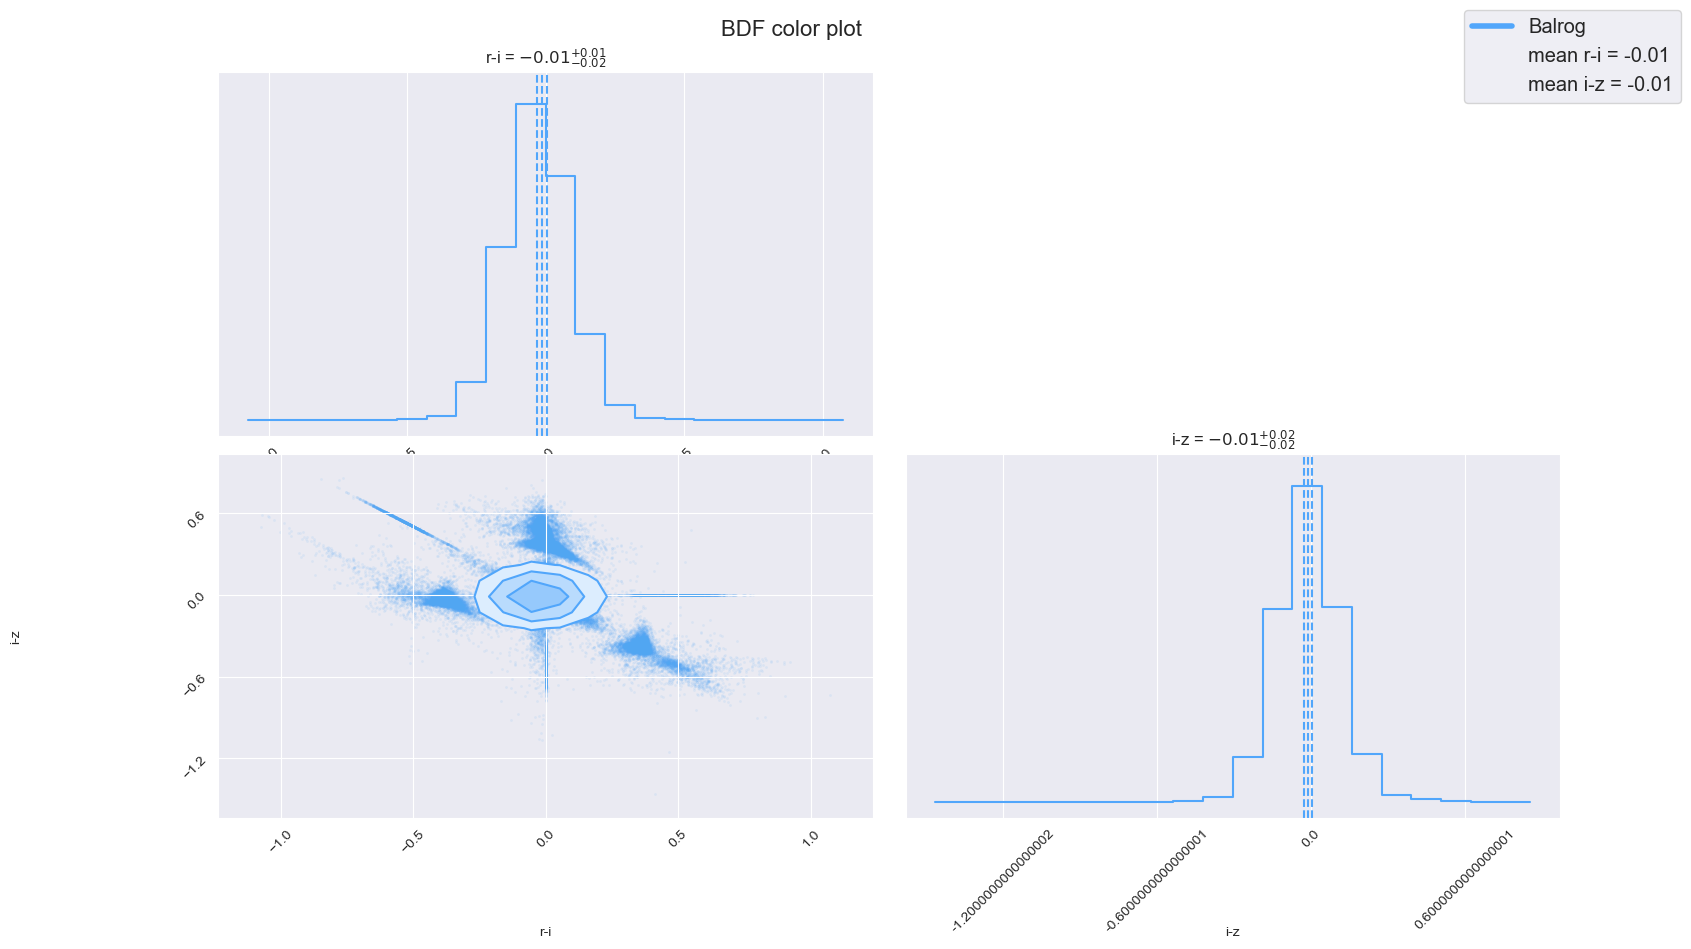

In [24]:
df_deep_field["Color BDF MAG r-i"] = flux2mag(df_deep_field["BDF_MAG_DERED_CALIB_R"]) - flux2mag(df_deep_field["BDF_MAG_DERED_CALIB_I"])
df_deep_field["Color BDF MAG i-z"] = flux2mag(df_deep_field["BDF_MAG_DERED_CALIB_I"]) - flux2mag(df_deep_field["BDF_MAG_DERED_CALIB_Z"])
plot_corner(
    data_frame=df_deep_field,
    columns=["Color BDF MAG r-i", "Color BDF MAG i-z"],
    title="BDF color plot",
    labels=["r-i", "i-z"],
    show_plot=False,
    save_plot=True,
    save_name=f"{path_plots}/bdf_color.png",
    ranges=None
)
df_deep_field.drop("Color BDF MAG r-i", axis=1, inplace=True)
df_deep_field.drop("Color BDF MAG i-z", axis=1, inplace=True)

# Observing conditions

In [25]:
infile = open(cfg["PATH_DATA"] + cfg["FILENAME_SURVEY"], 'rb')
df_survey = pd.DataFrame(pickle.load(infile, encoding='latin1'))
infile.close()

In [26]:
print('Length of survey catalog: {}'.format(len(df_survey)))

Length of survey catalog: 25608666


In [27]:
print(df_survey.isnull().sum())

HPIX_4096          0
AIRMASS_WMEAN_R    0
AIRMASS_WMEAN_I    0
AIRMASS_WMEAN_Z    0
FWHM_WMEAN_R       0
FWHM_WMEAN_I       0
FWHM_WMEAN_Z       0
MAGLIM_R           0
MAGLIM_I           0
MAGLIM_Z           0
EBV_SFD98          0
dtype: int64


In [28]:
print(df_survey.isnull().sum().sum())

0


/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_3118/1255656252.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hpxmap = np.zeros(npix, dtype=np.float)


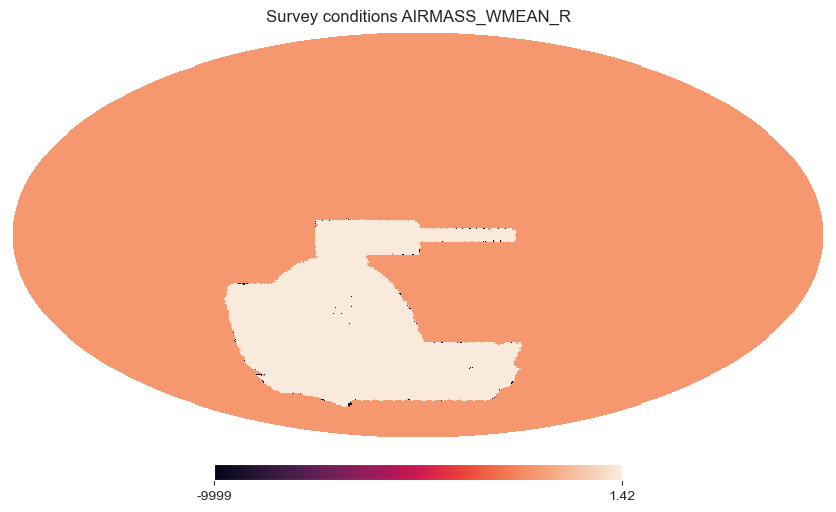

In [29]:
plot_healpixmap(
    data_frame=df_survey,
    nside=cfg["NSIDE"],
    col_name=f"AIRMASS_WMEAN_R",
    title="Survey conditions AIRMASS_WMEAN_R",
    show_plot=False,
    save_plot=True,
    save_name=f"{path_plots}/hpixmap_airmass.png"
)

# Merging catalogs

In [30]:
df_merged = pd.merge(df_detect, df_mcal, on='bal_id', how="left")

In [31]:
print('Length of merged mcal_detect catalog: {}'.format(len(df_merged)))

Length of merged mcal_detect catalog: 26442133


In [32]:
print(df_merged.isnull().sum())

bal_id                                 0
ID                                     0
detected                               0
true_ra                                0
true_dec                               0
match_flag_1.5_asec                    0
flags_foreground                       0
flags_badregions                       0
flags_footprint                        0
injection_counts                       0
HPIX_4096                              0
COADD_OBJECT_ID                 15191288
unsheared/ra                    15191288
unsheared/dec                   15191288
unsheared/snr                   15191288
unsheared/size_ratio            15191288
unsheared/flags                 15191288
unsheared/T                     15191288
unsheared/weight                15191288
unsheared/extended_class_sof    15191288
unsheared/flags_gold            15191288
unsheared/e_1                   15191288
unsheared/e_2                   15191288
unsheared/flux_r                15191288
unsheared/flux_i

In [33]:
print(df_merged.isnull().sum().sum())

273923022


In [34]:
df_merged = pd.merge(df_merged, df_deep_field, on='ID', how="left")

In [35]:
print('Length of merged mcal_detect_df catalog: {}'.format(len(df_merged)))

Length of merged mcal_detect_df catalog: 26442133


In [36]:
df_merged.keys()

Index(['bal_id', 'ID', 'detected', 'true_ra', 'true_dec',
       'match_flag_1.5_asec', 'flags_foreground', 'flags_badregions',
       'flags_footprint', 'injection_counts', 'HPIX_4096', 'COADD_OBJECT_ID',
       'unsheared/ra', 'unsheared/dec', 'unsheared/snr',
       'unsheared/size_ratio', 'unsheared/flags', 'unsheared/T',
       'unsheared/weight', 'unsheared/extended_class_sof',
       'unsheared/flags_gold', 'unsheared/e_1', 'unsheared/e_2',
       'unsheared/flux_r', 'unsheared/flux_i', 'unsheared/flux_z',
       'unsheared/flux_err_r', 'unsheared/flux_err_i', 'unsheared/flux_err_z',
       'RA', 'DEC', 'BDF_FLUX_DERED_CALIB_U', 'BDF_FLUX_DERED_CALIB_G',
       'BDF_FLUX_DERED_CALIB_R', 'BDF_FLUX_DERED_CALIB_I',
       'BDF_FLUX_DERED_CALIB_Z', 'BDF_FLUX_DERED_CALIB_J',
       'BDF_FLUX_DERED_CALIB_H', 'BDF_FLUX_DERED_CALIB_K',
       'BDF_FLUX_ERR_DERED_CALIB_U', 'BDF_FLUX_ERR_DERED_CALIB_G',
       'BDF_FLUX_ERR_DERED_CALIB_R', 'BDF_FLUX_ERR_DERED_CALIB_I',
       'BDF_FLUX_ER

In [37]:
print(df_merged.isnull().sum())

bal_id       0
ID           0
detected     0
true_ra      0
true_dec     0
            ..
BDF_T_ERR    0
BDF_G_0      0
BDF_G_1      0
TILENAME     0
FIELD        0
Length: 61, dtype: int64


In [38]:
for column in df_merged.columns:
    if df_merged[column].isnull().sum() > 0:
        print(f"{column}: {df_merged[column].isnull().sum()}")

COADD_OBJECT_ID: 15191288
unsheared/ra: 15191288
unsheared/dec: 15191288
unsheared/snr: 15191288
unsheared/size_ratio: 15191288
unsheared/flags: 15191288
unsheared/T: 15191288
unsheared/weight: 15191288
unsheared/extended_class_sof: 15191288
unsheared/flags_gold: 15191288
unsheared/e_1: 15191288
unsheared/e_2: 15191288
unsheared/flux_r: 15191288
unsheared/flux_i: 15191288
unsheared/flux_z: 15191288
unsheared/flux_err_r: 15351234
unsheared/flux_err_i: 15351234
unsheared/flux_err_z: 15351234


In [39]:
print(df_merged.isnull().sum().sum())

273923022


In [40]:
df_merged = pd.merge(df_merged, df_survey, on='HPIX_4096', how="left")

In [41]:
print('Length of merged mcal_detect_df_survey catalog with AIRMASS NANs: {}'.format(len(df_merged)))

Length of merged mcal_detect_df_survey catalog with AIRMASS NANs: 26442133


In [42]:
print(df_merged.isnull().sum())

bal_id               0
ID                   0
detected             0
true_ra              0
true_dec             0
                 ...  
FWHM_WMEAN_Z    138747
MAGLIM_R        138747
MAGLIM_I        138747
MAGLIM_Z        138747
EBV_SFD98       138747
Length: 71, dtype: int64


In [43]:
print(df_merged.isnull().sum().sum())

275310492


In [44]:
for column in df_merged.columns:
    if df_merged[column].isnull().sum() > 0:
        print(f"{column}: {df_merged[column].isnull().sum()}")

COADD_OBJECT_ID: 15191288
unsheared/ra: 15191288
unsheared/dec: 15191288
unsheared/snr: 15191288
unsheared/size_ratio: 15191288
unsheared/flags: 15191288
unsheared/T: 15191288
unsheared/weight: 15191288
unsheared/extended_class_sof: 15191288
unsheared/flags_gold: 15191288
unsheared/e_1: 15191288
unsheared/e_2: 15191288
unsheared/flux_r: 15191288
unsheared/flux_i: 15191288
unsheared/flux_z: 15191288
unsheared/flux_err_r: 15351234
unsheared/flux_err_i: 15351234
unsheared/flux_err_z: 15351234
AIRMASS_WMEAN_R: 138747
AIRMASS_WMEAN_I: 138747
AIRMASS_WMEAN_Z: 138747
FWHM_WMEAN_R: 138747
FWHM_WMEAN_I: 138747
FWHM_WMEAN_Z: 138747
MAGLIM_R: 138747
MAGLIM_I: 138747
MAGLIM_Z: 138747
EBV_SFD98: 138747


In [45]:
df_merged = df_merged[~df_merged['AIRMASS_WMEAN_R'].isnull()]

In [46]:
print('Length of merged mcal_detect_df_survey catalog without AIRMASS NANs: {}'.format(len(df_merged)))

Length of merged mcal_detect_df_survey catalog without AIRMASS NANs: 26303386


In [47]:
print(df_merged.isnull().sum())

bal_id          0
ID              0
detected        0
true_ra         0
true_dec        0
               ..
FWHM_WMEAN_Z    0
MAGLIM_R        0
MAGLIM_I        0
MAGLIM_Z        0
EBV_SFD98       0
Length: 71, dtype: int64


In [48]:
print(df_merged.isnull().sum().sum())

271427427


In [49]:
for column in df_merged.columns:
    if df_merged[column].isnull().sum() > 0:
        print(f"{column}: {df_merged[column].isnull().sum()}")

COADD_OBJECT_ID: 15052649
unsheared/ra: 15052649
unsheared/dec: 15052649
unsheared/snr: 15052649
unsheared/size_ratio: 15052649
unsheared/flags: 15052649
unsheared/T: 15052649
unsheared/weight: 15052649
unsheared/extended_class_sof: 15052649
unsheared/flags_gold: 15052649
unsheared/e_1: 15052649
unsheared/e_2: 15052649
unsheared/flux_r: 15052649
unsheared/flux_i: 15052649
unsheared/flux_z: 15052649
unsheared/flux_err_r: 15212564
unsheared/flux_err_i: 15212564
unsheared/flux_err_z: 15212564


# Drop columns

# SOME TESTS START

In [54]:
print(len(df_merged))
print(cfg['DEFAULTS'])

matching_values = df_merged.isin([cfg['DEFAULTS']["BDF_FLUX_DERED_CALIB_J"]])
matching_rows = df_merged["BDF_FLUX_DERED_CALIB_J"][matching_values.any(axis=1)]
print(len(matching_rows))
print(matching_rows)

26303386
{'BDF_FLUX_DERED_CALIB_J': -9999000000.0, 'BDF_FLUX_DERED_CALIB_H': -9999000000.0, 'BDF_FLUX_DERED_CALIB_K': -9999000000.0, 'BDF_MAG_DERED_CALIB_J': -9999000000.0, 'BDF_MAG_DERED_CALIB_H': -9999000000.0, 'BDF_MAG_DERED_CALIB_K': -9999000000.0, 'BDF_FLUX_ERR_DERED_CALIB_G': 9999000000.0, 'BDF_FLUX_ERR_DERED_CALIB_Z': 9999000000.0, 'BDF_FLUX_ERR_DERED_CALIB_J': 9999000000.0, 'BDF_FLUX_ERR_DERED_CALIB_H': 9999000000.0, 'BDF_FLUX_ERR_DERED_CALIB_K': 9999000000.0, 'unsheared/snr': -7070.360705084288, 'unsheared/T': -9999, 'unsheared/e_1': -9999, 'unsheared/e_2': -9999, 'AIRMASS_WMEAN_R': -9999, 'AIRMASS_WMEAN_I': -9999, 'AIRMASS_WMEAN_Z': -9999, 'FWHM_WMEAN_R': -9999, 'FWHM_WMEAN_I': -9999, 'FWHM_WMEAN_Z': -9999, 'MAGLIM_R': -9999, 'MAGLIM_I': -9999, 'MAGLIM_Z': -9999}
                    bal_id         ID  detected     true_ra   true_dec  \
240           100019101260  691667179         1    5.027295   1.576249   
241           102359100010  691667179         1  359.600820  -0.1021

In [116]:
# Initialize the combined mask with the same index as the dataframe
combined_mask = pd.Series([True] * len(df_merged), index=df_merged.index)

dict_test = {
    "DEFAULTS": {
        # "BDF_MAG_DERED_CALIB_J": -9999000000.0,
        # "BDF_MAG_DERED_CALIB_H": -9999000000.0,
        # "BDF_MAG_DERED_CALIB_K": -9999000000.0,
        # "BDF_FLUX_DERED_CALIB_J": -9999000000.0,
        # "BDF_FLUX_DERED_CALIB_H": -9999000000.0,
        # "BDF_FLUX_DERED_CALIB_K": -9999000000.0,
        # "BDF_FLUX_ERR_DERED_CALIB_G": 9999000000.0,
        # "BDF_FLUX_ERR_DERED_CALIB_Z": 9999000000.0,
        # "BDF_FLUX_ERR_DERED_CALIB_J": 9999000000.0,
        # "BDF_FLUX_ERR_DERED_CALIB_H": 9999000000.0,
        # "BDF_FLUX_ERR_DERED_CALIB_K": 9999000000.0,
        # 'unsheared/snr': -7070.360705084288,
        # 'unsheared/T': -9999,
        # "unsheared/e_1": -9999,
        # "unsheared/e_2": -9999,
        'AIRMASS_WMEAN_R': -9999,
        # 'AIRMASS_WMEAN_I': -9999,
        # 'AIRMASS_WMEAN_Z': -9999,
        # 'FWHM_WMEAN_R': -9999,
        # 'FWHM_WMEAN_I': -9999,
        # 'FWHM_WMEAN_Z': -9999,
        # 'MAGLIM_R': -9999,
        # 'MAGLIM_I': -9999,
        # 'MAGLIM_Z': -9999
    }
}
# Loop through each default value and update the combined mask
for column, default_value in dict_test['DEFAULTS'].items():
    if column in df_merged.columns:
        combined_mask &= (df_merged[column] == default_value)

# Check the index of combined_mask and df_merged for alignment
assert all(combined_mask.index == df_merged.index), "Index misalignment detected"

# Filter the dataframe to show only rows that match all default values
matching_rows = df_merged.loc[combined_mask]

# Print the matching rows
print(len(matching_rows))
print(len(df_merged) - 6263092)
print(len(df_merged) - len(matching_rows))
print(abs(20208363 - (len(df_merged) - len(matching_rows))))

78852
20040294
26224534
6016171


In [117]:
matching_rows.isna().sum()

bal_id          0
ID              0
detected        0
true_ra         0
true_dec        0
               ..
FWHM_WMEAN_Z    0
MAGLIM_R        0
MAGLIM_I        0
MAGLIM_Z        0
EBV_SFD98       0
Length: 71, dtype: int64

In [118]:
(matching_rows["detected"]==0).sum()

66984

In [119]:
df_merged_copy = df_merged
len_before = len(df_merged_copy)
print("Drop defaults")
if cfg["REPLACE_DEFAULTS"] is True:
    for col in dict_test["DEFAULTS"].keys():
        print(f"replace defaults drop: col={col} val={dict_test['DEFAULTS'][col]}")
        indices_to_drop = df_merged_copy[df_merged_copy[col] == dict_test['DEFAULTS'][col]].index
        df_merged_copy.drop(indices_to_drop, inplace=True)
    len_after = len(df_merged_copy)
    for k in df_merged_copy.keys():
        print(k, df_merged_copy[k].min(), df_merged_copy[k].max())
    print("Dropped {} rows".format(len_before - len_after))

Drop defaults
replace defaults drop: col=AIRMASS_WMEAN_R val=-9999
bal_id 100000002070 1023591000113069
ID 691667161 713198876
detected 0 1
true_ra 1.775860732777801e-05 359.9999962395703
true_dec -68.15892066384181 5.373543956465357
match_flag_1.5_asec 0 2
flags_foreground 0.0 89.0
flags_badregions 0.0 3.0
flags_footprint -1.6375e+30 1.0
injection_counts 1 54
HPIX_4096 10421 197142848
COADD_OBJECT_ID 2.0 165037.0
unsheared/ra 1.0829764773296157e-05 359.99998669364624
unsheared/dec -68.15897586420566 5.373420178634641
unsheared/snr -7070.360705084288 2156553.400697801
unsheared/size_ratio -0.8858235533203064 4879507.326539792
unsheared/flags 0.0 134217728.0
unsheared/T -9999.0 1461340.04300899
unsheared/weight 10.300535620007564 77.58102207403836
unsheared/extended_class_sof -9.0 3.0
unsheared/flags_gold 0.0 78.0
unsheared/e_1 -9999.0 0.9969103128995896
unsheared/e_2 -9999.0 0.9887702517824034
unsheared/flux_r -13425.081070802926 749704377.3916926
unsheared/flux_i -12421.117902058686 1

In [55]:
len_before = len(df_merged)
print("Drop defaults")
if cfg["REPLACE_DEFAULTS"] is True:
    for col in cfg["DEFAULTS"].keys():
        print(f"replace defaults drop: col={col} val={cfg['DEFAULTS'][col]}")
        indices_to_drop = df_merged[df_merged[col] == cfg['DEFAULTS'][col]].index
        df_merged.drop(indices_to_drop, inplace=True)
    len_after = len(df_merged)
    for k in df_merged.keys():
        print(k, df_merged[k].min(), df_merged[k].max())
    print("Dropped {} rows".format(len_before - len_after))

Drop defaults
replace defaults drop: col=BDF_FLUX_DERED_CALIB_J val=-9999000000.0


/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/3408311223.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(indices_to_drop, inplace=True)


replace defaults drop: col=BDF_FLUX_DERED_CALIB_H val=-9999000000.0
replace defaults drop: col=BDF_FLUX_DERED_CALIB_K val=-9999000000.0
replace defaults drop: col=BDF_MAG_DERED_CALIB_J val=-9999000000.0
replace defaults drop: col=BDF_MAG_DERED_CALIB_H val=-9999000000.0
replace defaults drop: col=BDF_MAG_DERED_CALIB_K val=-9999000000.0
replace defaults drop: col=BDF_FLUX_ERR_DERED_CALIB_G val=9999000000.0
replace defaults drop: col=BDF_FLUX_ERR_DERED_CALIB_Z val=9999000000.0
replace defaults drop: col=BDF_FLUX_ERR_DERED_CALIB_J val=9999000000.0
replace defaults drop: col=BDF_FLUX_ERR_DERED_CALIB_H val=9999000000.0
replace defaults drop: col=BDF_FLUX_ERR_DERED_CALIB_K val=9999000000.0
replace defaults drop: col=unsheared/snr val=-7070.360705084288
replace defaults drop: col=unsheared/T val=-9999
replace defaults drop: col=unsheared/e_1 val=-9999
replace defaults drop: col=unsheared/e_2 val=-9999
replace defaults drop: col=AIRMASS_WMEAN_R val=-9999
replace defaults drop: col=AIRMASS_WMEAN

In [56]:
print(len(df_merged))
print(len(df_merged[df_merged["detected"] == 1]))
print(len(df_merged[df_merged["detected"] == 0]))

20208363
8612535
11595828


In [140]:
df_merged_cut = df_merged.copy()
df_merged_cut = df_merged_cut[df_merged_cut["detected"]==1]
df_merged_cut["unsheared/mag_r"] = flux2mag(df_merged_cut["unsheared/flux_r"])
df_merged_cut["unsheared/mag_i"] = flux2mag(df_merged_cut["unsheared/flux_i"])
df_merged_cut["unsheared/mag_z"] = flux2mag(df_merged_cut["unsheared/flux_z"])
df_merged_cut = apply_cuts(cfg, df_merged_cut)

Apply unsheared object cuts
Length of catalog after applying unsheared object cuts: 11053722
Apply flag cuts
Length of catalog after applying flag cuts: 9520976
Apply unsheared shear cuts
Length of catalog after applying unsheared shear cuts: 3347267
perform binaries cut


/Users/P.Gebhardt/.conda/envs/GANdalf/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


len w/ binaries 3346815
define mask
pass:  3202051
fail:  144764
Apply unsheared mag cuts
Length of catalog after applying unsheared mag cuts: 3113177


In [143]:
dict_test = {
    "DEFAULTS": {
        "BDF_MAG_DERED_CALIB_J": -9999000000.0,
        "BDF_MAG_DERED_CALIB_H": -9999000000.0,
        "BDF_MAG_DERED_CALIB_K": -9999000000.0,
        "BDF_FLUX_DERED_CALIB_J": -9999000000.0,
        "BDF_FLUX_DERED_CALIB_H": -9999000000.0,
        "BDF_FLUX_DERED_CALIB_K": -9999000000.0,
        "BDF_FLUX_ERR_DERED_CALIB_G": 9999000000.0,
        "BDF_FLUX_ERR_DERED_CALIB_Z": 9999000000.0,
        "BDF_FLUX_ERR_DERED_CALIB_J": 9999000000.0,
        "BDF_FLUX_ERR_DERED_CALIB_H": 9999000000.0,
        "BDF_FLUX_ERR_DERED_CALIB_K": 9999000000.0,
        'unsheared/snr': -7070.360705084288,
        'unsheared/T': -9999,
        "unsheared/e_1": -9999,
        "unsheared/e_2": -9999,
        'AIRMASS_WMEAN_R': -9999,
        'AIRMASS_WMEAN_I': -9999,
        'AIRMASS_WMEAN_Z': -9999,
        'FWHM_WMEAN_R': -9999,
        'FWHM_WMEAN_I': -9999,
        'FWHM_WMEAN_Z': -9999,
        'MAGLIM_R': -9999,
        'MAGLIM_I': -9999,
        'MAGLIM_Z': -9999
    }
}
df_merged_cut_copy = df_merged_cut
len_before = len(df_merged_cut_copy)
combined_mask_cut = pd.Series([True] * len(df_merged_cut_copy), index=df_merged_cut_copy.index)
print("Drop defaults")
if cfg["REPLACE_DEFAULTS"] is True:
    # Loop through each default value and update the combined mask
    for column, default_value in dict_test['DEFAULTS'].items():
        combined_mask_cut = (df_merged_cut_copy[column] == default_value)
    
        # Check the index of combined_mask and df_merged for alignment
        assert all(combined_mask_cut.index == df_merged_cut_copy.index), "Index misalignment detected"

        # Filter the dataframe to show only rows that match all default values
        
        matching_rows_cut = df_merged_cut_copy.loc[combined_mask_cut]
        print(column, len(matching_rows_cut), len(df_merged_cut_copy), len(matching_rows_cut)/len(df_merged_cut_copy))
    # for col in dict_test["DEFAULTS"].keys():
    #     print(f"replace defaults drop: col={col} val={dict_test['DEFAULTS'][col]}")
    #     indices_to_drop = df_merged_cut_copy[df_merged_cut_copy[col] == dict_test['DEFAULTS'][col]].index
    #     print(indices_to_drop)
    #     # df_merged_cut_copy.drop(indices_to_drop, inplace=True)
    #     print(len(df_merged_cut_copy))
    len_after = len(df_merged_cut_copy)
    print("Dropped {} rows".format(len_before - len_after))

Drop defaults
BDF_MAG_DERED_CALIB_J 695740 3113177 0.2234823140476754
BDF_MAG_DERED_CALIB_H 695740 3113177 0.2234823140476754
BDF_MAG_DERED_CALIB_K 695740 3113177 0.2234823140476754
BDF_FLUX_DERED_CALIB_J 695740 3113177 0.2234823140476754
BDF_FLUX_DERED_CALIB_H 695740 3113177 0.2234823140476754
BDF_FLUX_DERED_CALIB_K 695740 3113177 0.2234823140476754
BDF_FLUX_ERR_DERED_CALIB_G 0 3113177 0.0
BDF_FLUX_ERR_DERED_CALIB_Z 1 3113177 3.212152730153152e-07
BDF_FLUX_ERR_DERED_CALIB_J 695740 3113177 0.2234823140476754
BDF_FLUX_ERR_DERED_CALIB_H 695740 3113177 0.2234823140476754
BDF_FLUX_ERR_DERED_CALIB_K 695740 3113177 0.2234823140476754
unsheared/snr 0 3113177 0.0
unsheared/T 0 3113177 0.0
unsheared/e_1 0 3113177 0.0
unsheared/e_2 0 3113177 0.0
AIRMASS_WMEAN_R 0 3113177 0.0
AIRMASS_WMEAN_I 0 3113177 0.0
AIRMASS_WMEAN_Z 0 3113177 0.0
FWHM_WMEAN_R 0 3113177 0.0
FWHM_WMEAN_I 0 3113177 0.0
FWHM_WMEAN_Z 0 3113177 0.0
MAGLIM_R 0 3113177 0.0
MAGLIM_I 0 3113177 0.0
MAGLIM_Z 0 3113177 0.0
Dropped 0 rows

In [144]:
infile = open(cfg["PATH_DATA"]+"gandalf_data_odet_ncuts_ndef_rnan_8612535.pkl", 'rb')
df_detected_test = pd.DataFrame(pickle.load(infile, encoding='latin1'))
infile.close()

In [145]:
df_detected_test_cut = df_detected_test.copy()
# df_detected_test_cut["unsheared/mag_r"] = flux2mag(df_detected_test_cut["unsheared/flux_r"])
# df_detected_test_cut["unsheared/mag_i"] = flux2mag(df_detected_test_cut["unsheared/flux_i"])
# df_detected_test_cut["unsheared/mag_z"] = flux2mag(df_detected_test_cut["unsheared/flux_z"])
df_detected_test_cut = apply_cuts(cfg, df_detected_test_cut)

Apply unsheared object cuts
Length of catalog after applying unsheared object cuts: 8554517
Apply flag cuts
Length of catalog after applying flag cuts: 7375026
Apply unsheared shear cuts
Length of catalog after applying unsheared shear cuts: 2595330
perform binaries cut


/Users/P.Gebhardt/.conda/envs/GANdalf/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


len w/ binaries 2595011
define mask
pass:  2482872
fail:  112139
Apply unsheared mag cuts
Length of catalog after applying unsheared mag cuts: 2417436


# END TEST

/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/116479496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Color unsheared MAG r-i"] = flux2mag(df_merged["unsheared/flux_r"]) - flux2mag(df_merged["unsheared/flux_i"])
/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/116479496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Color unsheared MAG i-z"] = flux2mag(df_merged["unsheared/flux_i"]) - flux2mag(df_merged["unsheared/flux_z"])
/var/folders/zz/

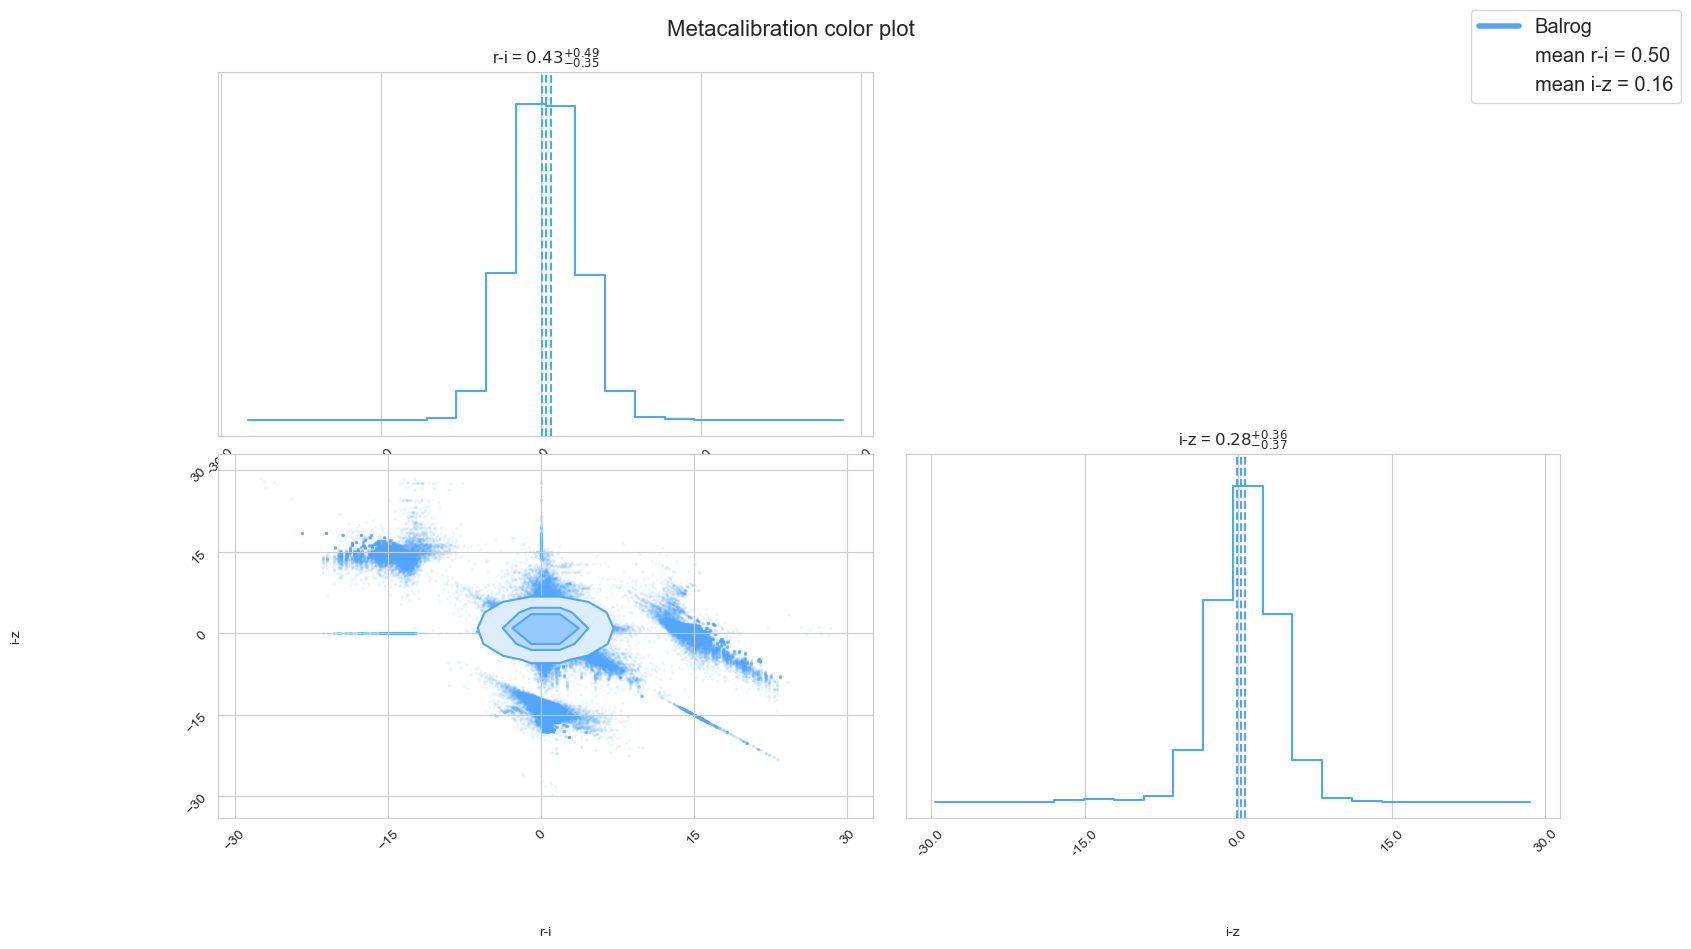

In [57]:
df_merged["Color unsheared MAG r-i"] = flux2mag(df_merged["unsheared/flux_r"]) - flux2mag(df_merged["unsheared/flux_i"])
df_merged["Color unsheared MAG i-z"] = flux2mag(df_merged["unsheared/flux_i"]) - flux2mag(df_merged["unsheared/flux_z"])
plot_corner(
    data_frame=df_merged[df_merged["detected"] == 1],
    columns=["Color unsheared MAG r-i", "Color unsheared MAG i-z"],
    title="Metacalibration color plot",
    labels=["r-i", "i-z"],
    show_plot=False,
    save_plot=True,
    save_name=f"{path_plots}/final_merged_cat_unsheared_color.png",
    ranges=None
)
df_merged.drop("Color unsheared MAG r-i", axis=1, inplace=True)
df_merged.drop("Color unsheared MAG i-z", axis=1, inplace=True)

/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/950062420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Color BDF MAG r-i"] = flux2mag(df_merged["BDF_MAG_DERED_CALIB_R"]) - flux2mag(df_merged["BDF_MAG_DERED_CALIB_I"])
/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/950062420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["Color BDF MAG i-z"] = flux2mag(df_merged["BDF_MAG_DERED_CALIB_I"]) - flux2mag(df_merged["BDF_MAG_DERED_CALIB_Z"])
/var/fol

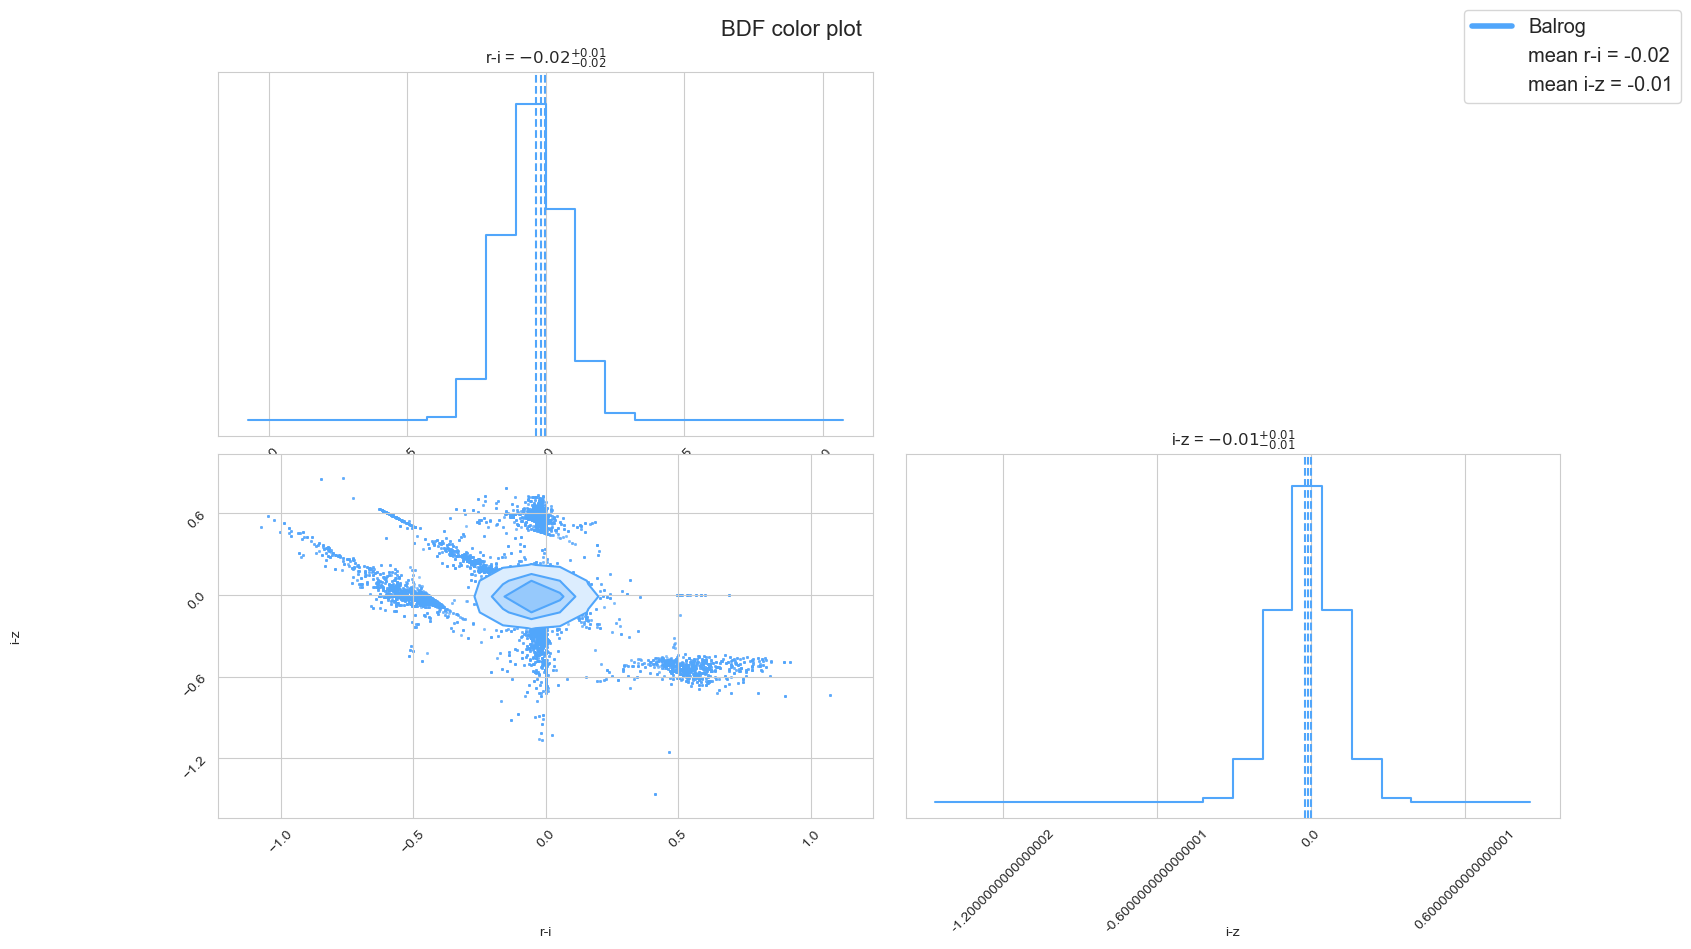

In [58]:
df_merged["Color BDF MAG r-i"] = flux2mag(df_merged["BDF_MAG_DERED_CALIB_R"]) - flux2mag(df_merged["BDF_MAG_DERED_CALIB_I"])
df_merged["Color BDF MAG i-z"] = flux2mag(df_merged["BDF_MAG_DERED_CALIB_I"]) - flux2mag(df_merged["BDF_MAG_DERED_CALIB_Z"])
plot_corner(
    data_frame=df_merged,
    columns=["Color BDF MAG r-i", "Color BDF MAG i-z"],
    title="BDF color plot",
    labels=["r-i", "i-z"],
    show_plot=False,
    save_plot=True,
    save_name=f"{path_plots}/final_merged_cat_bdf_color.png",
    ranges=None
)
df_merged.drop("Color BDF MAG r-i", axis=1, inplace=True)
df_merged.drop("Color BDF MAG i-z", axis=1, inplace=True)

In [59]:
df_merged.rename(
columns={
    'BDF_FLUX_DERED_CALIB_KS': 'BDF_FLUX_DERED_CALIB_K',
    'BDF_FLUX_ERR_DERED_CALIB_KS': 'BDF_FLUX_ERR_DERED_CALIB_K'},
inplace=True)

/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/1540952296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.rename(


In [60]:
df_merged["BDF_G"] = np.sqrt(df_merged["BDF_G_0"] ** 2 + df_merged["BDF_G_1"] ** 2)

/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/1359422999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["BDF_G"] = np.sqrt(df_merged["BDF_G_0"] ** 2 + df_merged["BDF_G_1"] ** 2)


In [61]:
print(df_merged.isna().sum())

bal_id       0
ID           0
detected     0
true_ra      0
true_dec     0
            ..
MAGLIM_R     0
MAGLIM_I     0
MAGLIM_Z     0
EBV_SFD98    0
BDF_G        0
Length: 72, dtype: int64


In [62]:
print(df_merged.isna().sum().sum())

208724904


In [63]:
for col in cfg['FILL_NA'].keys():
    df_merged[col].fillna(cfg['FILL_NA'][col], inplace=True)
    print(f"fill na default: col={col} val={cfg['FILL_NA'][col]}")

fill na default: col=unsheared/snr val=-0.05
fill na default: col=unsheared/T val=-0.8


/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/3159711350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[col].fillna(cfg['FILL_NA'][col], inplace=True)


fill na default: col=unsheared/size_ratio val=-0.95
fill na default: col=unsheared/weight val=10
fill na default: col=unsheared/flux_r val=-15000
fill na default: col=unsheared/flux_i val=-15000
fill na default: col=unsheared/flux_z val=-15000
fill na default: col=unsheared/flux_err_r val=1
fill na default: col=unsheared/flux_err_i val=1
fill na default: col=unsheared/flux_err_z val=1


In [64]:
print(df_merged.isna().sum())
print(df_merged.isna().sum().sum())
print(len(df_merged))

bal_id       0
ID           0
detected     0
true_ra      0
true_dec     0
            ..
MAGLIM_R     0
MAGLIM_I     0
MAGLIM_Z     0
EBV_SFD98    0
BDF_G        0
Length: 72, dtype: int64
92766624
20208363


In [65]:
df_merged = calc_color(
    cfg=cfg,
    data_frame=df_merged,
    mag_type=("MAG", "BDF"),
    flux_col=("BDF_FLUX_DERED_CALIB", "BDF_FLUX_ERR_DERED_CALIB"),
    mag_col=("BDF_MAG_DERED_CALIB", "BDF_MAG_ERR_DERED_CALIB"),
    bins=cfg['BDF_BINS'],
    save_name=f"bdf_mag"
)
df_merged = calc_color(
    cfg=cfg,
    data_frame=df_merged,
    mag_type=("MAG", "unsheared"),
    flux_col=("unsheared/flux", "unsheared/flux_err"),
    mag_col=("unsheared/mag", "unsheared/mag_err"),
    bins=cfg['UNSHEARED_BINS'],
    save_name=f"unsheared/mag"
)

/Users/P.Gebhardt/Development/PhD/Balrog/Handler/helper_functions.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f"{mag_col[0]}_{b}"] = flux2mag(data_frame[f"{flux_col[0]}_{b}"])
/Users/P.Gebhardt/Development/PhD/Balrog/Handler/helper_functions.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f"{mag_col[1]}_{b}"] = flux2mag(data_frame[f"{flux_col[1]}_{b}"])
/Users/P.Gebhardt/Development/PhD/Balrog/Handler/helper_functions.py:222: SettingWithCopyWarning: 
A value is trying t

In [66]:
df_merged_yj = df_merged.copy()

In [67]:
df_merged_yj, dict_merged_yj_transformer = get_yj_transformer(
    data_frame=df_merged_yj,
    columns=cfg['YJ_TRANSFORM_COLS_JPY']
)

/var/folders/zz/s_yjp9t10d559chz303nb8900000gq/T/ipykernel_52693/1255656252.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hpxmap = np.zeros(npix, dtype=np.float)


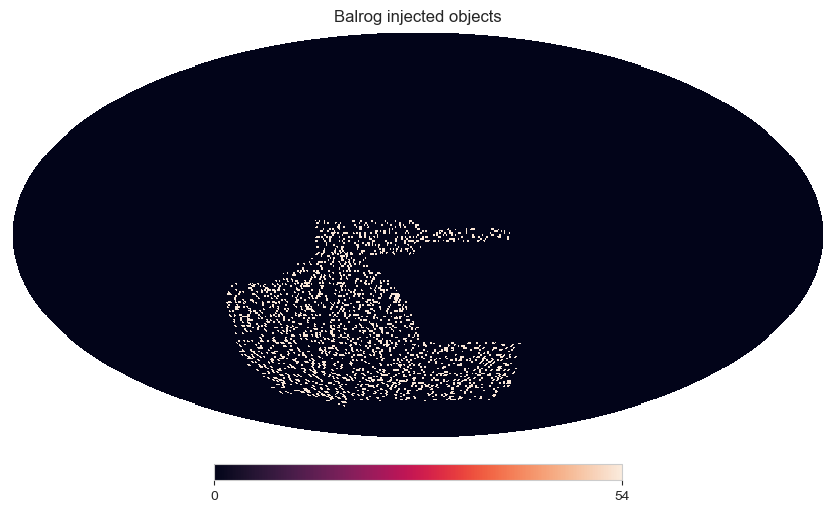

In [71]:
plot_healpixmap(
    data_frame=df_merged,
    nside=cfg["NSIDE"],
    col_name="injection_counts",
    title="Balrog injected objects",
    show_plot=False,
    save_plot=True,
    save_name=f"{path_plots}/hpixmap_detect_cat.png"
)

In [75]:
print(len(df_detect))
print(len(df_detect[df_detect["detected"] == 1]))
print(len(df_detect[df_detect["detected"] != 1]))

26442133
11250845
15191288


In [78]:
scaler = get_scaler(
    data_frame=df_merged_yj[cfg['SCALER_COLS_MAG']]
)
merged_yj_scaled = scaler.transform(df_merged_yj[cfg['SCALER_COLS_MAG']])
df_merged_yj_scaled = pd.DataFrame(merged_yj_scaled, columns=cfg['SCALER_COLS_MAG'])

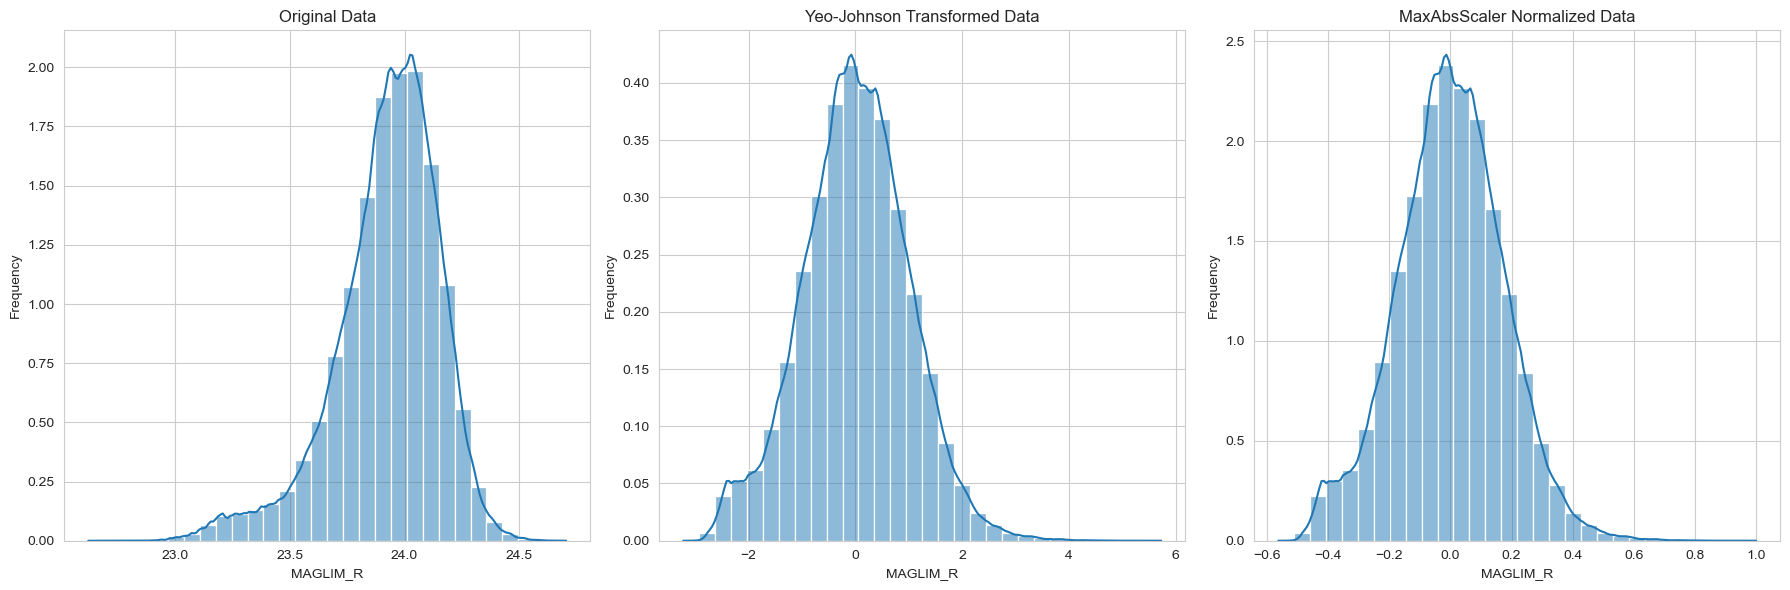

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original data
sns.histplot(df_merged["MAGLIM_R"], kde=True, ax=axes[0], stat="density", bins=30)
axes[0].set_title("Original Data")
axes[0].set_xlabel("MAGLIM_R")
axes[0].set_ylabel("Frequency")

# Yeo-Johnson transformed data
sns.histplot(df_merged_yj["MAGLIM_R"], kde=True, ax=axes[1], stat="density", bins=30)
axes[1].set_title("Yeo-Johnson Transformed Data")
axes[1].set_xlabel("MAGLIM_R")
axes[1].set_ylabel("Frequency")

# MaxAbsScaler normalized data
sns.histplot(df_merged_yj_scaled["MAGLIM_R"], kde=True, ax=axes[2], stat="density", bins=30)
axes[2].set_title("MaxAbsScaler Normalized Data")
axes[2].set_xlabel("MAGLIM_R")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig(f"{path_plots}/transformed_data.png", dpi=200)
plt.show()

In [ ]:
assert cfg['SIZE_TRAINING_SET'] + cfg['SIZE_VALIDATION_SET'] + cfg['SIZE_TEST_SET'] == 1
valid_test_ratio = cfg['SIZE_VALIDATION_SET'] / (cfg['SIZE_VALIDATION_SET'] + cfg['SIZE_TEST_SET'])

df_train, df_temp = train_test_split(df_merged_yj_scaled, train_size=cfg['SIZE_TRAINING_SET'])
df_valid, df_test = train_test_split(df_temp, train_size=valid_test_ratio)